<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/07_DepthModel_CreateDataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path
from zipfile import ZipFile
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc
from tqdm.auto import tqdm
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision.transforms as T
import glob
import torch
import sys
sns.set()

In [0]:
dataset_path = Path('/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/')

In [0]:
os.listdir(dataset_path)

['label_info.txt',
 'fg_bg_mask.zip',
 'fg.zip',
 'bg.zip',
 'depth_fg_bg.zip',
 'fg_bg.zip',
 'fg_bg_small.zip',
 'fg_bg_mask_small.zip',
 'bg_small.zip',
 'bg_192.zip',
 'depth_fg_bg_small.zip']

In [0]:
def plot_sample(sample):
    '''
    Plots a given sample of the dataset
    '''
    bg, fg_bg, fg_bg_mask, depth_fg_bg = sample['bg'].permute(1, 2, 0).numpy(), sample['fg_bg'].permute(1, 2, 0).numpy(), sample['fg_bg_mask'][0].numpy(), sample['depth_fg_bg'][0].numpy()
    fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

    ax[0, 0].imshow(bg) ; ax[0, 0].axis('off')

    ax[0, 1].imshow(fg_bg) ; ax[0, 1].axis('off')

    ax[1, 0].imshow(fg_bg_mask) ; ax[1, 0].axis('off')

    ax[1, 1].imshow(depth_fg_bg) ; ax[1, 1].axis('off')

    fig.tight_layout()

    plt.show()


In [0]:
dataset = DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

dataset folders/files already exists in data/Vathos
found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images


In [0]:
sample = dataset[340000]

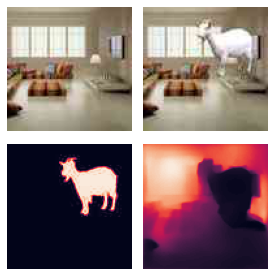

In [0]:
DenseDepth.plot_sample(sample)

In [0]:
# 70 - 30 split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
len(train_subset), len(test_subset)

(280000, 120000)

In [0]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=512, shuffle=True, num_workers=2)

In [0]:
import sys
sys.path.insert(0, 'ProjektDepth')

In [0]:
! git clone https://github.com/satyajitghana/ProjektDepth.git

fatal: destination path 'ProjektDepth' already exists and is not an empty directory.


In [0]:
%load_ext autoreload
%autoreload 2

import vathos.data_loader as vloader
import vathos.model as vmodel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
vloader.DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

dataset folders/files already exists in data/Vathos
found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images


In [0]:
from torchsummary import summary

In [0]:
summary(vmodel.ResUNeXt(), input_size=(6, 96, 96), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             384
       BatchNorm2d-2           [-1, 64, 96, 96]             128
       BatchNorm2d-3            [-1, 6, 96, 96]              12
              ReLU-4            [-1, 6, 96, 96]               0
            Conv2d-5          [-1, 320, 96, 96]           1,920
       BatchNorm2d-6          [-1, 320, 96, 96]             640
              ReLU-7          [-1, 320, 96, 96]               0
            Conv2d-8          [-1, 320, 96, 96]          28,800
       BatchNorm2d-9          [-1, 320, 96, 96]             640
             ReLU-10          [-1, 320, 96, 96]               0
           Conv2d-11           [-1, 64, 96, 96]          20,480
    ResDoubleConv-12           [-1, 64, 96, 96]               0
        MaxPool2d-13           [-1, 64, 48, 48]               0
     ResDownBlock-14  [[-1, 64, 48, 48]